# Process Powers et. al. data
This notebook does the following:

1. Select template experiment. This template experiment will be used in the next [notebook](2_identify_generic_genes_pathways.ipynb) to simulate experiments with the same experimental design but testing a different biological process.


2.  Process Powers et. al. data. Data was downloaded from [here](https://www.synapse.org/#!Synapse:syn22685451) and saved to a local directory.

3. Train VAE on data

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

In [2]:
import os
import pandas as pd
import pickle
from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

### Set parameters for data processing

Most parameters are read from `config_filename`. We manually selected bioproject [GSE11352](https://www.ncbi.nlm.nih.gov/gds/?term=GSE11352[Accession]) as the template experiment, which contains breast cell lines treated with estradiol at 12H, 24H and 48H.

In [3]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_validate.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]
dataset_name = params["dataset_name"]

# File that contains gene ranks identified by Crow et. al.
DE_prior_filename = params['reference_gene_filename']

# Template experiment ID
project_id = params['project_id']

# Column name containing sample ids
metadata_colname = params['metadata_colname']

# Output file: pickled list of shared genes(generated during gene ID mapping)
shared_genes_filename = params['shared_genes_filename']

# Output files of template experiment data
mapped_template_filename = params['mapped_template_filename']
processed_template_filename = params['processed_template_filename']

# Output files of Rani's compendium data
raw_compendium_filename = params['raw_compendium_filename']
mapped_compendium_filename = params['mapped_compendium_filename']
normalized_compendium_filename = params['normalized_compendium_filename']

# Output file: pickled scaler (generated during compendium normalization)
scaler_filename = params['scaler_filename']

### Load compendium data

In [4]:
raw_compendium = pd.read_csv(raw_compendium_filename, header=0, index_col = 0)
print(raw_compendium.shape)
raw_compendium.head()

(7381, 2411)


,Probe,GSM259581,GSM259582,GSM259583,GSM259584,GSM259585,GSM259586,GSM259587,GSM259588,GSM259589,...,GSM252476,GSM252477,GSM252478,GSM252479,GSM252480,GSM252481,GSM252482,GSM252483,GSM252484,GSM252485
Gene_Symbol,,,,,,,,,,,,,,,,,,,,,
FSCB,224274_at,3.098393,3.213481,3.274801,3.199369,3.153272,3.128445,3.380986,3.268357,3.237945,...,3.288410,3.538975,3.218280,3.342328,3.464212,3.274194,3.300703,3.472638,3.266334,3.466383
MT-ND4,224372_at,14.658800,14.668680,14.303190,14.652650,13.538480,14.205400,13.515800,14.497080,14.719580,...,13.830090,13.852900,13.515740,13.660870,13.932890,13.810090,13.797720,13.966090,13.863600,13.868280
MT-ND5,1555653_at,13.144220,13.332740,12.863990,13.710070,11.015600,12.152890,11.551480,12.969400,13.337430,...,12.811840,12.505650,12.644310,12.629280,12.610060,11.279770,12.767380,12.644800,12.860420,12.451390
PPP1R2,236754_at,7.490983,5.670741,6.079725,7.620370,6.170191,6.958352,6.813191,8.230337,6.735595,...,3.748531,5.010586,3.556642,4.118902,4.691676,4.244480,5.800878,4.982851,4.417427,4.132561
SEC16B,239618_at,3.241639,3.231134,2.874084,2.965641,2.919233,2.964495,2.831708,2.974571,2.817225,...,2.588555,2.853227,2.736293,2.759132,2.712342,2.813158,2.632547,2.721186,2.960828,2.701740


### Process compendium data

1. Drop probe column
2. Transpose
3. Get only shared genes from Crow et. al.
4. Normalize

In [5]:
# Drop probe column and transpose matrix to be sample x gene
processed_compendium = raw_compendium.drop(columns='Probe').T

# Get only gene expression data for genes in Crow et. al.
our_gene_ids_hgnc = list(processed_compendium.columns)

published_generic_genes = process.get_published_generic_genes(DE_prior_filename)
shared_genes_hgnc = list(
    set(our_gene_ids_hgnc).intersection(published_generic_genes)
)

# In Python, the order of elements in a list that is converted from a set
# is non-deterministic, so it is sorted here to have reproducible result.
shared_genes_hgnc.sort()

# Pickle `shared_genes_hgnc` and save as `shared_genes_filename`
if not os.path.exists(shared_genes_filename):
    with open(shared_genes_filename, 'wb') as pkl_fh:
        pickle.dump(shared_genes_hgnc, pkl_fh)

mapped_compendium = processed_compendium[shared_genes_hgnc]
print(mapped_compendium.shape)
mapped_compendium.head()

(2410, 6763)


Gene_Symbol,A2M,A2M-AS1,A2ML1,A4GNT,AACSP1,AADAC,AAK1,AARS2,ABCA1,ABCA13,...,ZSWIM3,ZSWIM5,ZSWIM6,ZSWIM8,ZSWIM8-AS1,ZXDA,ZXDB,ZYG11B,ZZEF1,ZZZ3
GSM259581,11.23209,5.829954,4.595342,4.228431,3.209473,4.603809,9.477858,7.007373,8.411876,3.071042,...,6.634953,7.244251,8.797199,5.291696,6.762994,5.354261,7.223416,8.880719,8.959975,7.981907
GSM259582,11.54458,5.490599,4.910140,4.661489,3.353542,4.646417,9.209405,7.134890,8.415479,2.991593,...,6.857504,5.925541,8.822709,5.045814,6.563953,5.240730,7.457722,8.970101,8.173791,7.557069
GSM259583,11.02134,5.745314,4.910849,4.546454,3.148500,4.812263,9.391009,6.946416,8.669145,2.856758,...,6.838577,5.800442,9.104460,5.233314,6.402519,5.413173,7.928393,8.979970,8.417014,7.790276
GSM259584,12.14316,6.609886,4.808511,4.419452,3.143053,4.632672,9.269085,7.166478,8.835999,2.917594,...,6.243281,5.989613,9.814856,4.838007,6.746724,5.484284,8.121392,9.210998,8.865220,8.108037
GSM259585,11.15296,6.013789,4.909912,4.343109,3.070543,4.481789,9.199475,6.967982,8.956426,2.980324,...,6.869718,5.590476,8.566863,5.323962,6.364874,5.714663,8.650623,9.111313,6.955924,9.189531


In [6]:
# Save
mapped_compendium.to_csv(mapped_compendium_filename, sep="\t")

In [7]:
# Normalize data
process.normalize_compendium(
    mapped_compendium_filename,
    normalized_compendium_filename,
    scaler_filename
)

### Select and process template data

1. Get gene expression associated with `project_id`, which was manually selected by the user and specified in the config file.

2. Drop selected samples from template experiments based on metadata, `data/metadata/all_experiments_sample_annotations.csv`, which contains sample comparisons

Note: The data is not normalized so that we can perform DE analysis in next notebook

In [8]:
# Note: This is the only notebook using this function, so for now it is included here
# Get sample ids associated with selected project id
def get_sample_ids(experiment_id, mapping_filename):
    """
    Return sample ids for a given experiment id

    """
    # Read in metadata
    metadata = pd.read_csv(mapping_filename, header=0)
    metadata.set_index('gse', inplace=True)
    
    selected_metadata = metadata.loc[experiment_id]
    sample_ids = list(selected_metadata[metadata_colname])

    return sample_ids

# metadata file with mapping from experiment to sample
experiment_to_sample_metadata_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "all_experiments_sample_annotations.csv"
)

sample_ids = get_sample_ids(project_id, experiment_to_sample_metadata_filename)

# Get expression data
template_mapped = mapped_compendium.loc[sample_ids]
print(template_mapped.shape)

# Save
template_mapped.to_csv(mapped_template_filename, sep="\t")

(18, 6763)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [9]:
# metadata file with grouping assignments for samples
sample_id_metadata_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_process_samples.tsv"
)
    
# Drop sample ids based on metadata file above
sample_ids_to_drop = set()
if os.path.exists(sample_id_metadata_filename):
    # Read in metadata and get samples to be dropped:
    metadata = pd.read_csv(
        sample_id_metadata_filename, sep='\t', header=0, index_col=0
    )
    sample_ids_to_drop = set(metadata[metadata["processing"] == "drop"].index)

# Write the processed recount2 template output file on disk
with open(mapped_template_filename) as ifh, open(processed_template_filename, "w") as ofh:
    for idx, line in enumerate(ifh):
        sample_id = line.split('\t')[0]
        if idx == 0 or sample_id not in sample_ids_to_drop:
            ofh.write(line)

### Train VAE 

In [10]:
# Create VAE directories if needed
output_dirs = [
    os.path.join(base_dir, dataset_name, "models"),
    os.path.join(base_dir, dataset_name, "logs")
]

NN_architecture = params['NN_architecture']

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    sub_dir = os.path.join(each_dir, NN_architecture)
    os.makedirs(sub_dir, exist_ok=True)

input dataset contains 2410 samples and 6763 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Instructions for updating:
Use tf.cast instead.
Train on 1808 samples, validate on 602 samples
Epoch 1/40
1808/1808 [==============================] - 90s 50ms/step - loss: 4396.8681 - val_loss: 7652.8389
Epoch 2/40
1808/1808 [==============================] - 90s 50ms/step - loss: 4353.3403 - val_loss: 4588.9786
Epoch 3/40
1808/1808 [==============================] - 90s 50ms/step - loss: 4334.8866 - val_loss: 4337.9001
Epoch 4/40
1808/1808 [==============================] - 90s 50ms/step - loss: 4323.9342 - val_loss: 4980.0588
Epoch 5/40
1808/1808 [==============================] - 90s 50ms/step - loss: 4312.8118 - val_loss: 4525.5309
Epoch 6/40
1808/1808 [==============================] - 92s 51ms/step - loss: 4302.2871 - val_loss: 4313.3615
Epoch 7/40
1808/1808 [==============================] - 92s 51ms/step - loss: 4293.2458 - val_loss: 4341.1292
Epoch 8/40
1808/1808 [==============================] - 92s 51ms/step - loss: 4281.0804 - val_loss: 4487.6549
Epoch 9/40
1808/1808 [===

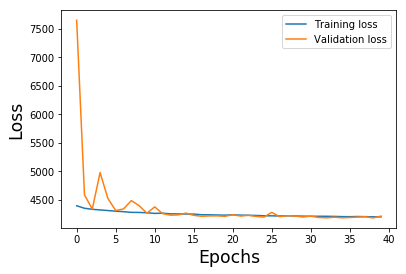

In [11]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_filename, normalized_compendium_filename)